# _Resampling w/ SMOTE_

__July 9, 2019__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [4]:
path = Path(os.getcwd())
path = path / 'data'
path
# GCP path variable
#path = Config.data_path()
#path

PosixPath('/Users/joeai/Springboard/capstone_2/data')

# _Load in Data_

In [5]:
# read in csv files for training and validation sets
train_df = pd.read_csv(path/'CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv(path/'CheXpert-v1.0-small/valid.csv')
print(train_df.shape)
print(valid_df.shape)

(223414, 19)
(234, 19)


In [6]:
# add valid column to indicate if observations are part of validation set
train_df['valid'] = False
valid_df['valid'] = True

In [7]:
# extract patient id, study and add to columns
train_df['Patient_id'] = train_df.Path.str.split('/', 3, True)[2]
valid_df['Patient_id'] = valid_df.Path.str.split('/', 3, True)[2]

train_df['study'] = train_df.Path.str.split('/',4,True)[3]
valid_df['study'] = valid_df.Path.str.split('/',4,True)[3]

In [8]:
# create function to seed data (allows us to more easily reproduce sample data set)
def seed_data(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
pathology_list = list(train_df.columns[5:19])
pathology_list

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [10]:
train_df[pathology_list] = train_df[pathology_list].fillna(0)

In [11]:
train_df[pathology_list] = train_df[pathology_list].astype(int)

In [12]:
train_df.isnull().sum()

Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
No Finding                        0
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
valid                             0
Patient_id                        0
study                             0
dtype: int64

In [13]:
train_df['AP/PA'] = train_df['AP/PA'].fillna('')

In [14]:
# drop uncertain observations
from test_folder import replicate

train_df = replicate.uignore(train_df, 'Cardiomegaly')
train_df.head()

Dropped -1 observations.
------------------------------
Converted pathology column into integer type.
------------------------------
Shape of new dataframe: (215327, 22)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,valid,Patient_id,study
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,1,False,patient00001,study1
1,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,False,patient00002,study1
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,,0,0,0,1,0,0,-1,0,0,0,0,0,1,0,False,patient00002,study1
3,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,0,False,patient00003,study1
4,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,patient00004,study1


In [15]:
train_df['Sex'] = train_df['Sex'].astype('category')

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215327 entries, 0 to 215326
Data columns (total 22 columns):
Path                          215327 non-null object
Sex                           215327 non-null category
Age                           215327 non-null int64
Frontal/Lateral               215327 non-null object
AP/PA                         215327 non-null object
No Finding                    215327 non-null int64
Enlarged Cardiomediastinum    215327 non-null int64
Cardiomegaly                  215327 non-null int64
Lung Opacity                  215327 non-null int64
Lung Lesion                   215327 non-null int64
Edema                         215327 non-null int64
Consolidation                 215327 non-null int64
Pneumonia                     215327 non-null int64
Atelectasis                   215327 non-null int64
Pneumothorax                  215327 non-null int64
Pleural Effusion              215327 non-null int64
Pleural Other                 215327 non-null int64

# _Resampling_

In [39]:
# create list of potentially relevant features
labels = list(train_df.drop(['Path', 'Frontal/Lateral', 'AP/PA', 'Cardiomegaly', 'valid', 'Patient_id', 'study'], axis=1)
              .columns)
labels

['Sex',
 'Age',
 'No Finding',
 'Enlarged Cardiomediastinum',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

In [60]:
X = train_df[labels]
y = train_df['Cardiomegaly']

In [61]:
print(X.shape, y.shape)

(215327, 15) (215327,)


# _Python imbalanced-learn module PCA_

In [44]:
import imblearn

In [62]:
from sklearn.datasets import make_classification

X, y = make_classification(n_classes = 2, n_clusters_per_class=1, n_samples=100, random_state=1)

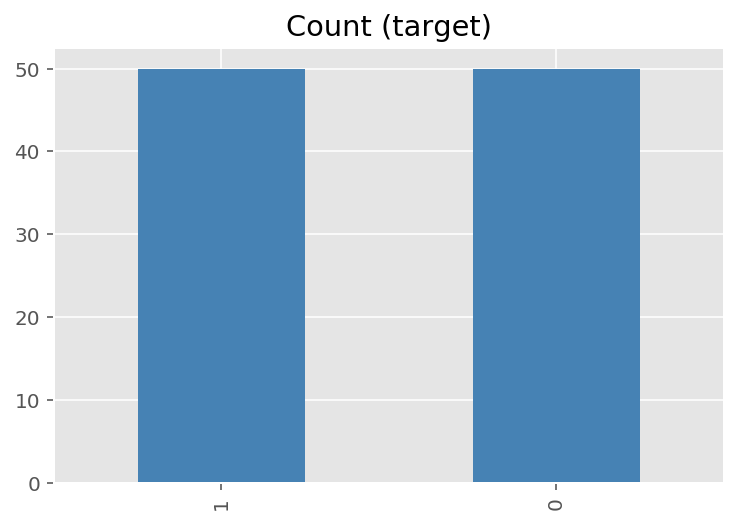

In [63]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)', color = 'steelblue');

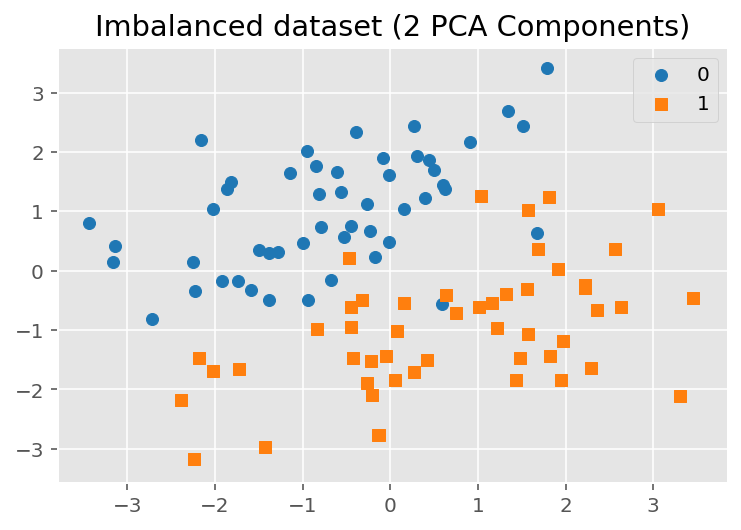

In [64]:
# reduce size of dataset using principal component analysis (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, df['target'], 'Imbalanced dataset (2 PCA Components)')

In [51]:
# drop single unknown Sex observation
df = df[df['Sex'] != 'Unknown'].reset_index(drop=True)

In [52]:
df.shape

(215326, 16)

In [53]:
df.tail()

,Sex,Age,No Finding,Enlarged Cardiomediastinum,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,target
215321,Male,59,0,0,-1,0,0,0,0,-1,0,1,0,0,0,0
215322,Male,59,0,0,-1,0,0,0,0,-1,0,-1,0,0,0,0
215323,Female,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
215324,Female,0,0,0,1,0,0,0,-1,1,0,0,0,0,0,1
215325,Female,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder

# instantiate labelencoder object
le = LabelEncoder()

In [55]:
# Fit the encoder to the pandas column
le.fit(df['Sex'])

# View the labels (if you want)
list(le.classes_)

# Apply the fitted encoder to the pandas column
df['Sex'] = le.transform(df['Sex'].copy())

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215326 entries, 0 to 215325
Data columns (total 16 columns):
Sex                           215326 non-null int64
Age                           215326 non-null int64
No Finding                    215326 non-null int64
Enlarged Cardiomediastinum    215326 non-null int64
Lung Opacity                  215326 non-null int64
Lung Lesion                   215326 non-null int64
Edema                         215326 non-null int64
Consolidation                 215326 non-null int64
Pneumonia                     215326 non-null int64
Atelectasis                   215326 non-null int64
Pneumothorax                  215326 non-null int64
Pleural Effusion              215326 non-null int64
Pleural Other                 215326 non-null int64
Fracture                      215326 non-null int64
Support Devices               215326 non-null int64
target                        215326 non-null int64
dtypes: int64(16)
memory usage: 26.3 MB


In [57]:
# create 2-dimensional plot function to see data distribution
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()